<a href="https://colab.research.google.com/github/Kathyllen/Compesa/blob/matr%C3%ADculas/Estudo_De_Encerramentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importações

In [511]:
import re
import nltk
import unicodedata
import numpy as np
import pandas as pd
import datetime as dt
import xgboost as xgb
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from collections import defaultdict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [512]:
path_train = r'/content/20221025_Estudo_Encerramentos.xlsx'
path_predict = r'/content/Estudo de encerramentos.xlsx'

train_df = pd.read_excel(path_train)
predict_df = pd.read_excel(path_predict)

<ipython-input-512-cab0ff8dea43>:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  train_df = pd.read_excel(path_train)


In [513]:
predict_df = predict_df.loc[~predict_df['Número OS'].isin(train_df['Número OS'])]

In [514]:
predict_df['GERENCIA'].value_counts()

GNM OESTE                 1066
GNR SAO FRANCISCO          976
GNR AGRESTE CENTRAL        644
GNM NORTE                  520
GNM LESTE                  498
GNM CENTRO SUL             415
GNM SUL                    390
GNR IPOJUCA                385
GNM CENTRO NORTE           353
GNR AGRESTE MERIDIONAL     306
GNR MATA NORTE             228
GNR RUSSAS                 212
GNR MATA SUL               180
GNR ALTO CAPIBARIBE        167
GNM CENTRO                  75
Name: GERENCIA, dtype: int64

In [515]:
predict_df_sampled = predict_df[predict_df['GERENCIA'] == 'GNM CENTRO NORTE']

In [516]:
#predict_df_sampled = predict_df.sample(50, random_state = 3)

In [517]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Número OS        1576 non-null   int64         
 1   IMOV_ID          1576 non-null   int64         
 2   GERENCIA         1576 non-null   object        
 3   Município        1576 non-null   object        
 4   AM Geração OS    1576 non-null   int64         
 5   AM Encer OS      1576 non-null   int64         
 6   Dt Geração OS    1576 non-null   datetime64[ns]
 7   Dt Encer OS      1576 non-null   datetime64[ns]
 8   Tipo Serviço OS  1576 non-null   object        
 9   Unid Abert OS    1576 non-null   object        
 10  Motivo encer OS  1576 non-null   object        
 11  Parecer Enc OS   1576 non-null   object        
 12  Comentários      1576 non-null   object        
 13  Conclusão        1576 non-null   object        
dtypes: datetime64[ns](2), int64(4), object(8

In [518]:
limite_train = train_df.shape[0]

In [519]:
train_df['Conclusão'] = (train_df['Conclusão']
                         .replace(['É possível realizar o serviço.', 'Não é possível realizar o serviço.', 'Não precisa gerar outra OS. ', 'Gerar OS de remoção.', 'Gerar OS para instalar HD.', 'Inconclusivo'], 
                   [0, 1, 1, 2, 3, 4]))

In [520]:
train_df['Conclusão'].value_counts()

0    762
1    561
4    121
2     82
3     50
Name: Conclusão, dtype: int64

In [521]:
dataframe = pd.concat([train_df, predict_df_sampled], axis = 0).copy()

In [522]:
dataframe['Dt Encer OS'] = pd.to_datetime(dataframe['Dt Encer OS'])

today = pd.datetime.today()

dataframe['TEMPO_DESDE_ENCERRAMENTO'] = (dt.datetime(2022, 11, 3) - dataframe['Dt Encer OS'])

<ipython-input-522-cd487c4f836f>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime.today()


In [523]:
dataframe['TEMPO_DESDE_ENCERRAMENTO'] = dataframe['TEMPO_DESDE_ENCERRAMENTO'].dt.days

In [524]:
# dataframe = dataframe.drop(columns = ['Localidade', 'Número OS', 'IMOV_ID', 'AM Geração OS', 'AM Encer OS', 'Dt Geração OS', 'Dt Encer OS'])
dataframe = dataframe.drop(columns = ['Localidade', 'Número OS', 'AM Geração OS', 'AM Encer OS', 'Dt Geração OS', 'Dt Encer OS'])

In [525]:
Var_Categoricas = ['GERENCIA', 'Município', 'Tipo Serviço OS', 'Unid Abert OS', 'Motivo encer OS']

In [526]:
dataframe[Var_Categoricas] = dataframe[Var_Categoricas].astype('category')

In [527]:
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode

    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self

    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)

    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

In [528]:
multi = MultiColumnLabelEncoder(columns = Var_Categoricas)
encoded_data = multi.fit_transform(dataframe)

In [529]:
dataframe_encoded = pd.DataFrame(encoded_data, columns = dataframe.columns)

In [530]:
dataframe_encoded

,IMOV_ID,GERENCIA,Município,Tipo Serviço OS,Unid Abert OS,Motivo encer OS,Parecer Enc OS,Comentários,Conclusão,TEMPO_DESDE_ENCERRAMENTO
0,57860731,0,47,1,1,15,"CLIENTE NAO PERMITIU, MAS SOLICITOU O CARRO, P...","Nada físico impede de fazer o serviço, apenas ...",0.0,12
1,68325994,1,40,1,1,15,HD nAo localizado,Pode ter sido um problema temporário,0.0,12
2,68380863,1,40,1,1,15,HD nAo localizado,"Segundo as fotos anteriores, o imóvel era outro.",0.0,12
3,57921285,0,47,1,1,15,TUBETE COLADO,Não dá para saber se foi colado ou se está sot...,4.0,12
4,57920963,0,47,1,1,15,TUBETE COLADO,Concretaram dentro da caixa de proteção do HD ...,1.0,12
...,...,...,...,...,...,...,...,...,...,...
7664,68180511,1,40,1,1,7,-,NaN,NaN,-15
7670,15680601,1,40,1,1,0,cliente nAo permitiu,NaN,NaN,34
7673,68202868,1,40,1,1,7,-,NaN,NaN,-27
7678,16253316,1,40,1,1,0,"cliente nAo permitiu,",NaN,NaN,82


In [531]:
#Função para tirar símbolos e acentos e deixar o texto em lowercase:
def remove_punctuation(text):
  # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', text)
    no_punct = u"".join([c for c in nfkd if not unicodedata.combining(c)])

    # Uso de re para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', no_punct.lower())

In [532]:
dataframe_encoded['Parecer Enc OS'] = dataframe_encoded['Parecer Enc OS'].apply(lambda x:remove_punctuation(x))

In [533]:
#Função para remover as palavras da lista:
lista_palavras = ['dia', 'visita', 'realizada', 'antonio', 'amos', 'sendo', 'santana']
def remove_words(text):
  if(type(text)==float):
    return text
  ans=""  
  for texto in text:     
    if texto not in lista_palavras:
      ans+= " " + texto
  return ans.lstrip()

In [534]:
dataframe_encoded['Parecer Enc OS'] = dataframe_encoded['Parecer Enc OS'].apply(lambda x:remove_words(x.split()))

In [535]:
train_df_ = dataframe_encoded.iloc[:limite_train,:].copy()

predict_df_ = dataframe_encoded.iloc[limite_train:,:].copy()

In [536]:
x_vec = train_df_['Parecer Enc OS'].values

ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range = (1, 3), stop_words = set(stopwords.words('portuguese')))

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(x_vec))
x_ctv = ctv.transform(x_vec) 

# Add the columns from the sparse matrix to the existing DataFrame
x_vec_com_tudo = train_df_.assign(**{col: x_ctv[:, i].toarray().ravel() for i, col in enumerate(ctv.get_feature_names_out())})

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [537]:
x_vec_pred = predict_df_['Parecer Enc OS'].values

ctv_pred = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range = (1, 3), stop_words = set(stopwords.words('portuguese')))

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv_pred.fit(list(x_vec_pred))
x_ctv_pred = ctv_pred.transform(x_vec_pred) 

# Add the columns from the sparse matrix to the existing DataFrame
x_vec_com_tudo_pred = (predict_df_.assign(**{col: x_ctv_pred[:, i]
                                             .toarray()
                                             .ravel() for i, col in enumerate(ctv_pred.get_feature_names())})).copy()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [538]:
# Removendo os dados que não se repetem pelo menos duas vezes
x_vec_temp = (x_vec_com_tudo_pred.iloc[:,9:]
              .loc[:, x_vec_com_tudo_pred.iloc[:,9:]
                   .sum() > 1]).copy()

x_vec_filtered = pd.concat([x_vec_com_tudo_pred.iloc[:,1:9], x_vec_temp], axis=1).drop(columns= ['Parecer Enc OS', 'Comentários', 'Conclusão']).copy()

### XGBoost

In [539]:
Y = x_vec_com_tudo.iloc[:, 8]

X = x_vec_com_tudo.loc[:, x_vec_com_tudo.columns.intersection(x_vec_filtered.columns)]

x = x_vec_com_tudo.loc[:, x_vec_com_tudo.columns.intersection((pd.concat([x_vec_com_tudo_pred.iloc[:,:9], x_vec_temp], axis=1).drop(columns= ['Parecer Enc OS', 'Comentários', 'Conclusão']).copy()).columns)]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

In [540]:
reg = xgb.XGBClassifier()

reg.fit(X_train, Y_train,
        eval_metric="auc")

XGBClassifier(objective='multi:softprob')

Accuracy do modelo: 86.39%


Confusion Matrix:


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


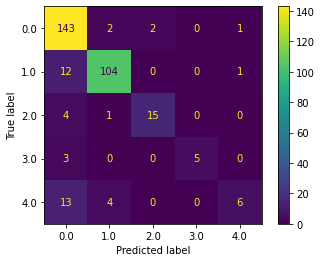

In [541]:
#ypred = reg.predict_proba(X_test)

#ypred = reg.predict(X_test)

print("Accuracy do modelo: {:.2%}".format(accuracy_score(ypred,Y_test)))
print('\n')
print('Confusion Matrix:')

plot_confusion_matrix(reg, X_test, Y_test)

plt.show()

In [542]:
unique, counts = np.unique(ypred, return_counts=True)

In [543]:
X_pred = x_vec_com_tudo_pred.loc[: , x_vec_com_tudo_pred.columns[x_vec_com_tudo_pred.columns.isin(X)]]

x_pred = x_vec_com_tudo_pred.loc[: , x_vec_com_tudo_pred.columns[x_vec_com_tudo_pred.columns.isin(x)]]

y_pred_x = reg.predict(X_pred)

y_pred_x_index = reg.predict(X_pred.sort_index())

In [559]:
previsões = pd.concat([multi.inverse_transform(x_pred).reset_index().drop(columns='index'), 
                       pd.Series(y_pred_x, name = 'Predição'),
                       pd.Series(reg.predict_proba(X_pred)[:,1], name = 'Probabilidade')], axis = 1)

In [564]:
previsões.sort_values(by='Probabilidade', ascending = False)

,IMOV_ID,GERENCIA,Município,Tipo Serviço OS,Unid Abert OS,Motivo encer OS,TEMPO_DESDE_ENCERRAMENTO,01,29092022,3,...,terreo nao,terreo nao permitiu,toda,troca,troca hd,troca pois,vizinhos,vizinhos cliente,Predição,Probabilidade
306,105964760,GNM CENTRO NORTE,OLINDA,SUBSTITUICAO DE HIDROMETRO,HIDROMETROPOLITANA DEMANDA DE SERVICO,SERVICO JA EXECUTADO,61,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.931337
74,15788046,GNM CENTRO NORTE,OLINDA,SUBSTITUICAO DE HIDROMETRO,HIDROMETROPOLITANA DEMANDA DE SERVICO,SERVICO JA EXECUTADO,29,0,0,0,...,0,0,0,1,1,0,0,0,1.0,0.928148
182,15689757,GNM CENTRO NORTE,OLINDA,SUBSTITUICAO COM REMOCAO,HIDROMETROPOLITANA DEMANDA DE SERVICO,SERVICO JA EXECUTADO,65,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.922400
329,16085278,GNM CENTRO NORTE,OLINDA,SUBSTITUICAO DE HIDROMETRO,HIDROMETROPOLITANA DEMANDA DE SERVICO,SERVICO JA EXECUTADO,34,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.922384
206,15712511,GNM CENTRO NORTE,OLINDA,SUBSTITUICAO DE HIDROMETRO,HIDROMETROPOLITANA DEMANDA DE SERVICO,SERVICO JA EXECUTADO,28,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.904531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,16388521,GNM CENTRO NORTE,OLINDA,SUBSTITUICAO DE HIDROMETRO,HIDROMETROPOLITANA DEMANDA DE SERVICO,CLIENTE NAO PERMITIU,-31,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.003343
318,16033650,GNM CENTRO NORTE,OLINDA,SUBSTITUICAO DE HIDROMETRO,HIDROMETROPOLITANA DEMANDA DE SERVICO,CLIENTE NAO PERMITIU,-31,0,0,0,...,0,0,0,1,0,1,0,0,0.0,0.002969
338,103629360,GNM CENTRO NORTE,OLINDA,SUBSTITUICAO DE HIDROMETRO,HIDROMETROPOLITANA DEMANDA DE SERVICO,IMOVEL FECHADO,14,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.002440
173,36664339,GNM CENTRO NORTE,OLINDA,SUBSTITUICAO DE HIDROMETRO,HIDROMETROPOLITANA DEMANDA DE SERVICO,IMOVEL FECHADO,14,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.002440


In [545]:
previsões.to_excel('GNM_CENTRO_NORTE_Previsões.xlsx')

### Top 20 Features importances

In [546]:
'''dici = dict(zip(X.columns, reg.feature_importances_))

dici = dict(sorted(dici.items(), key=lambda item: item[1], reverse=True))

features = list(dici.keys())

fig, axes = plt.subplots(figsize = (8, 5))

plt.title('Feature Importance', fontsize = 15)

importances = reg.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), features, rotation = 90)
plt.show()'''

"dici = dict(zip(X.columns, reg.feature_importances_))\n\ndici = dict(sorted(dici.items(), key=lambda item: item[1], reverse=True))\n\nfeatures = list(dici.keys())\n\nfig, axes = plt.subplots(figsize = (8, 5))\n\nplt.title('Feature Importance', fontsize = 15)\n\nimportances = reg.feature_importances_\nindices = np.argsort(importances)[::-1]\n\nplt.bar(range(20), importances[indices[:20]])\nplt.xticks(range(20), features, rotation = 90)\nplt.show()"

### Learning Curve

In [547]:
'''train_sizes, train_scores, test_scores = learning_curve(reg, X, Y, cv=5)

# calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot the learning curve
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()'''

'train_sizes, train_scores, test_scores = learning_curve(reg, X, Y, cv=5)\n\n# calculate the mean and standard deviation of the scores\ntrain_scores_mean = np.mean(train_scores, axis=1)\ntrain_scores_std = np.std(train_scores, axis=1)\ntest_scores_mean = np.mean(test_scores, axis=1)\ntest_scores_std = np.std(test_scores, axis=1)\n\n# plot the learning curve\nplt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.1)\nplt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.1)\nplt.plot(train_sizes, train_scores_mean, \'o-\', color="r", label="Training Score")\nplt.plot(train_sizes, test_scores_mean, \'o-\', color="g", label="Cross-Validation Score")\n\nplt.xlabel("Training Examples")\nplt.ylabel("Score")\nplt.legend(loc="best")\nplt.show()'